In [2]:
import os, os.path, glob, pickle
import numpy as np
import pint.toa as pt
import pint.models as pm
import pint.fitter as pf
import pint.residuals as pr
from pint.fitter import ConvergenceFailure
import pint.logging
import timing_analysis.utils as utils
from timing_analysis.timingconfiguration import TimingConfiguration
from astropy import log
import astropy.units as au
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time
pint.logging.setup(level="ERROR")
plt.rcParams.update({'font.size': 22})

ModuleNotFoundError: No module named 'timing_analysis'

In [ ]:
class Pred_par:
    # Need configfile to initiate the class
    def __init__(self,psr,configfile,MJDlow=57000.0*au.d,MJDhigh=58000.0*au.d,SNRcut=8.0,zthres=1.0): 
        self.configfile=configfile
        self.psr=psr
        self.MJDlow=MJDlow
        self.MJDhigh=MJDhigh
        self.SNRcut=SNRcut
        self.zthres=zthres
        tc=TimingConfiguration(self.configfile)
        self.tc = tc
        
    # Load the original 15yr TOAs and model
    def load_toas(self):
        mo,to = self.tc.get_model_and_toas(excised=True,usepickle=True)
        if not to: mo,to = self.tc.get_model_and_toas(apply_initial_cuts=True)
        return mo,to
    
    # Apply manual cuts
    def cut_toas(self,to):
        self.tc.manual_cuts(to)
    
    # Read and merge recent TOAs 
    def load_merge_qck_toas(self,tqfilenms,quicklookdir,to,mo):
        # Read in all the recent quicklook TOAs
        tq = pt.get_TOAs(tqfilenms, model=mo) 
        # Remove all quicklook TOAs below our SNR threshold
        snrs = np.asarray([float(snr) for snr in tq.get_flag_value("snr")[0]])
        tq.table = tq.table[snrs > self.SNRcut]
        # Combine the TOAs
        tall = pt.merge_TOAs([to, tq])
        return tall
    
    # Remove all lines that begin with the following
        # FD params, FB derivs (but not FB0), all DMX params, and red noise params
        # and for TEMPO compatability, also remove SWM, troposphere, and 
        # planet shapiro correction.  And finally, remove ECORR.
        # also remove JUMP statement that correspond to an old receiver not making the MJD cut
    def simplify_parfile(self, tall, parout,otherflag=None):
        """Convert a complicated 15yr parfile into a simplified parfile"""
        rcvr=np.unique(tall.get_flag_value("fe")[0])
        #rcvr=np.unique(tall.table['fe'])
        a=tall.table['fe','mjd']
        for rc in rcvr:
            x=str(rc)==a["fe"]
            mjdcut = Time(self.MJDlow, format='mjd', scale='utc')
            maxmjd=(max(a["mjd"][x]))
            if((max(a["mjd"][x])) < mjdcut):
                print("Reciever jump must be removed from model: ", rc)
                otherflag=f"fe {rc}"
        
        parin = self.tc.get_model_path()
        remove = ["FD", "FB", "DMX", "RN", "SWM", "CORRECT", "PLANET", "INFO", "DMDATA", "NE_SW", "ECORR"]
        with open(parin, "r") as fi, open(parout, "w") as fo:
            for line in fi:
                if line.startswith("CLOCK"):
                    line = line.replace("CLOCK", "CLK")
                    line = line.replace("BIPM2019", "BIPM")
                if otherflag is not None:
                    if otherflag in line:
                        line = None
                        break
                for param in remove:
                    if line.startswith(param):
                        if not line.startswith("FB0"):
                            line = None
                            break
                if line is not None:
                    fo.write(line)
        ms = pm.get_model(parout)
        return ms  
    
    # Freeze/fix all the fitted parameters 
    def freeze_fit_pars(self,ms): 
        for param in ms.free_params:
            getattr(ms, param).frozen = True
        # Explicitly fit for F0, DM, and JUMPs
        getattr(ms, "F0").frozen = False
        getattr(ms, "DM").frozen = False
        getattr(ms, "JUMP1").frozen = False
        if hasattr(ms, "JUMP2"):
            getattr(ms, "JUMP2").frozen = False
        if hasattr(ms, "JUMP3"):
            getattr(ms, "JUMP3").frozen = False
        # If this is a black widow, fit for TASC and FB0
        if hasattr(ms, "FB0") and ms.FB0.value is not None:
            getattr(ms, "FB0").frozen = False
            getattr(ms, "TASC").frozen = False
        print("Free params:", ms.free_params)
        
    # Fit TOAs using a simple WLS fitter    
    def fit_TOAs(self,tall,ms,iterations):
        f = pf.DownhillWLSFitter(tall, ms)
        try:
            f.fit_toas(maxiter=iterations)
            f.model.CHI2.value = f.resids.chi2
        except ConvergenceFailure:
            log.warning('Failed to converge; moving on with best result.')
        print("Postfit RMS = ", f.resids.rms_weighted())
        return f
    
    # Use z-score to remove outliers
    def cut_outliers(self,f):
        stddev= np.std(f.resids.time_resids)
        mean=np.mean(f.resids.time_resids) 
        zscore=np.fabs(((f.resids.time_resids-mean)/stddev).decompose())
        zcut=zscore<self.zthres
        N0 = tall.ntoas
        tall.table = tall.table[zcut]
        print(f"Removing {N0-zcut.sum()} TOAs of {N0} as outliers")


Pulsars for which predictive par files are being generated:  {'J1853+1303', 'B1855+09', 'J2017+0603', 'J2043+1711', 'J1640+2224', 'J0931-1902', 'J0509+0856', 'J0605+3757', 'J1903+0327', 'J0636+5128', 'J0437-4715', 'J1745+1017', 'J0709+0458', 'J0645+5158', 'J1705-1903', 'J1910+1256', 'J1012+5307', 'J1747-4036', 'J2302+4442', 'J0406+3039', 'J1455-3330', 'J1312+0051', 'J1843-1113', 'J1741+1351', 'J2124-3358', 'J1744-1134', 'J0340+4130', 'J1738+0333', 'J0023+0923', 'J1918-0642', 'J1453+1902', 'J1125+7819', 'J1614-2230', 'J1802-2124', 'J0613-0200', 'J1600-3053', 'J1946+3417', 'B1937+21', 'J1923+2515', 'J1022+1001', 'J0030+0451', 'J1911+1347', 'J0557+1551', 'J1944+0907', 'J2010-1323', 'J2317+1439', 'J1024-0719', 'J1012-4235', 'J1713+0747', 'J2033+1734', 'J1832-0836', 'J2214+3000', 'J1751-2857', 'B1953+29', 'J1643-1224', 'J2322+2057', 'J2234+0611', 'J2234+0944', 'J1730-2304', 'J1909-3744', 'J2145-0750', 'J0614-3329', 'J1630+3734', 'J2229+2643', 'J0740+6620', 'J0610-2100', 'J1811-2405', 'J1719

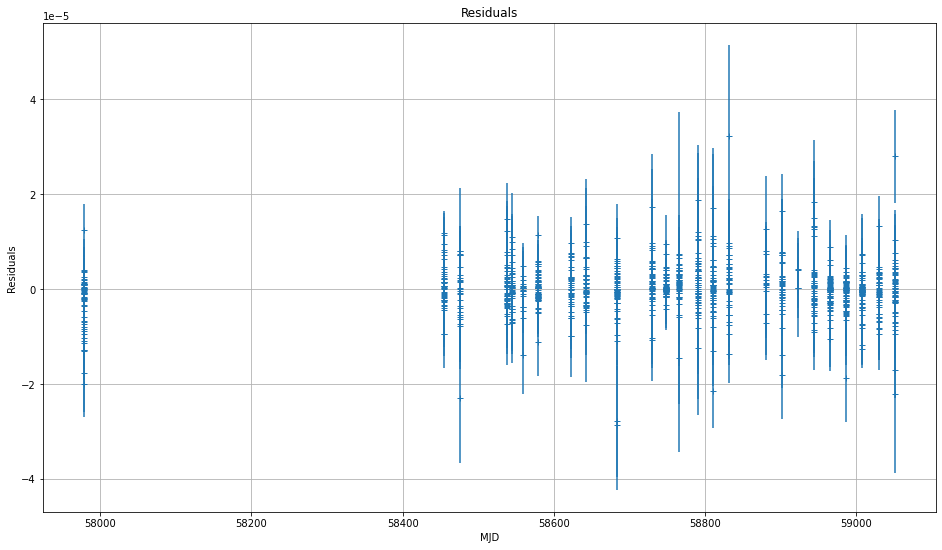

Removing 231 TOAs of 1124 as outliers
Postfit RMS =  1.1194291244228476 us


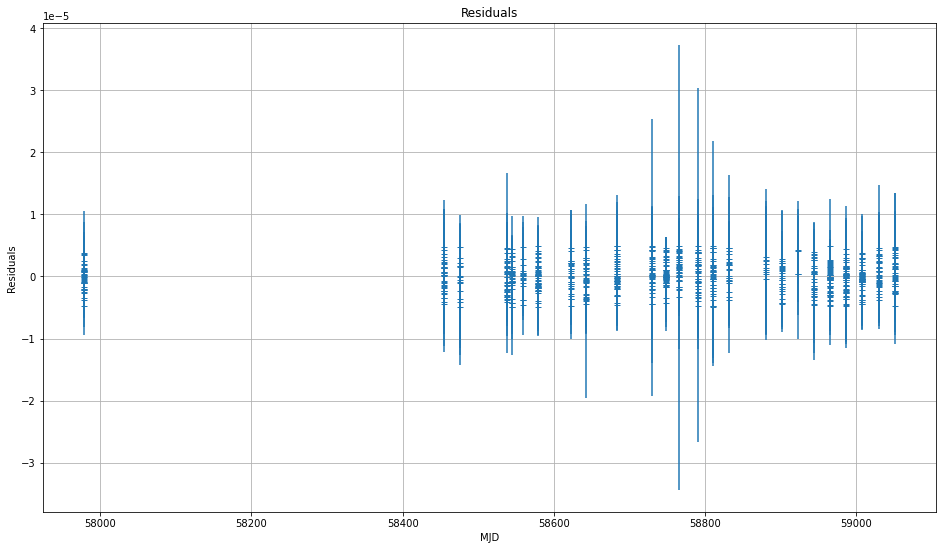

Working on B1855+09
INFO: Par file created: 2022-03-01T20:28:52.056929 [timing_analysis.timingconfiguration]
INFO: Selecting 7758 TOAs out of 9828 (2070 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 7758 TOAs out of 9828 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 7758 TOAs out of 9828 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  1.2690969760803523 us


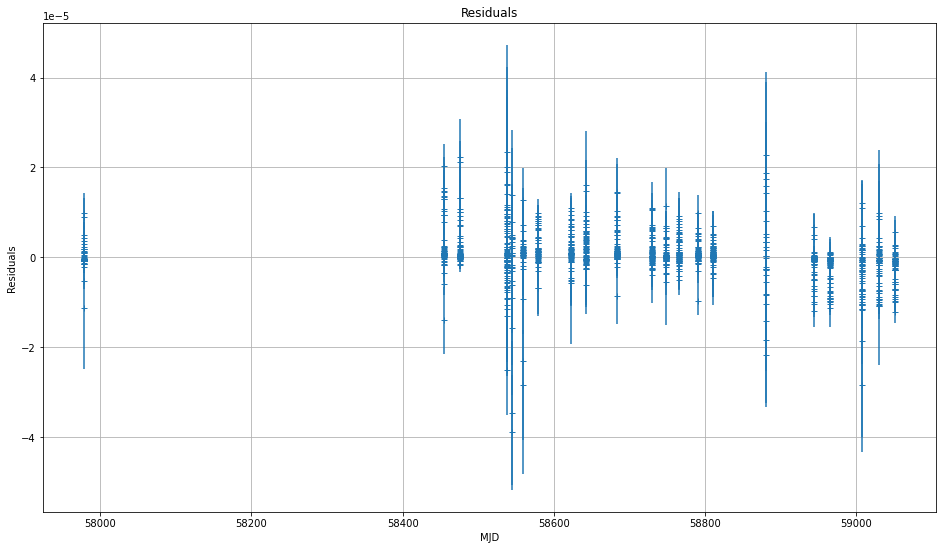

Removing 262 TOAs of 1258 as outliers
Postfit RMS =  0.7758043564125734 us


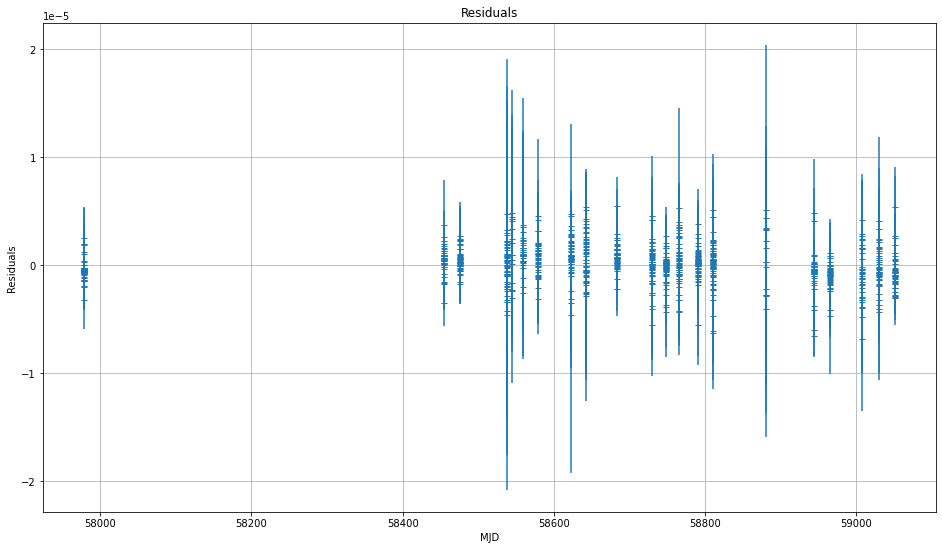

Working on J2017+0603
INFO: Par file created: 2022-03-02T03:37:40.461561 [timing_analysis.timingconfiguration]
INFO: Selecting 3516 TOAs out of 9450 (5934 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 3512 TOAs out of 9450 (4 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 3512 TOAs out of 9450 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Reciever jump must be removed from model:  430
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  0.8797078197042002 us


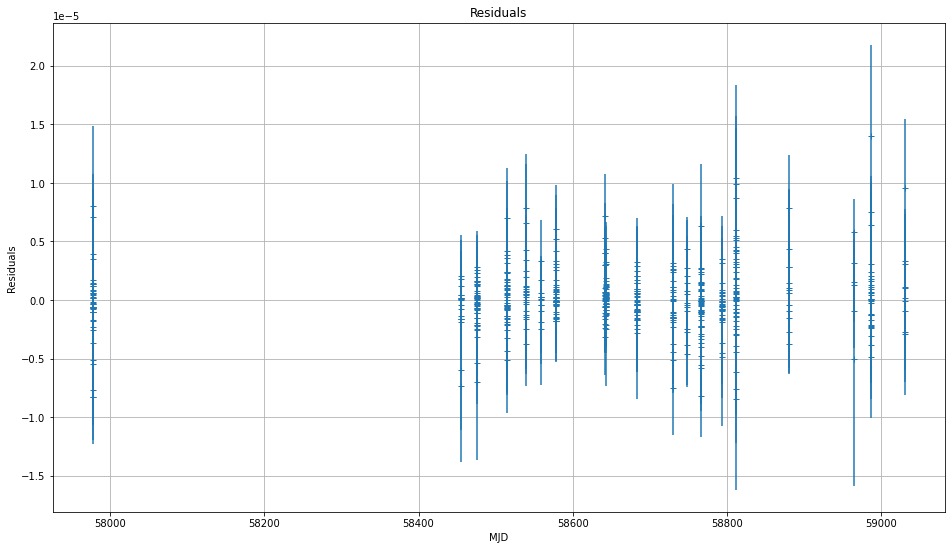

Removing 128 TOAs of 588 as outliers
Postfit RMS =  0.6310222081700732 us


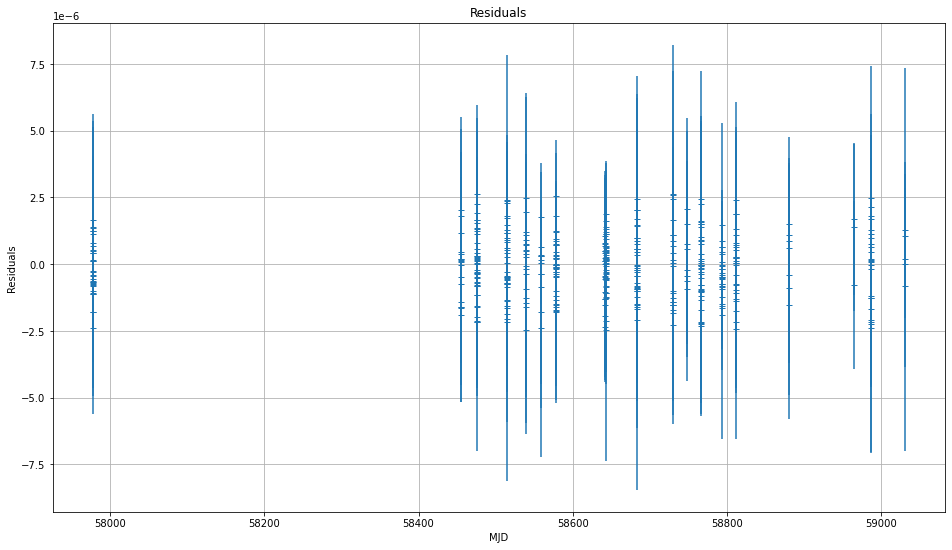

Working on J2043+1711
INFO: Par file created: 2022-03-02T15:55:46.037891 [timing_analysis.timingconfiguration]
INFO: Selecting 7406 TOAs out of 21266 (13860 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 7398 TOAs out of 21266 (8 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 7398 TOAs out of 21266 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  1.2558282953091728 us


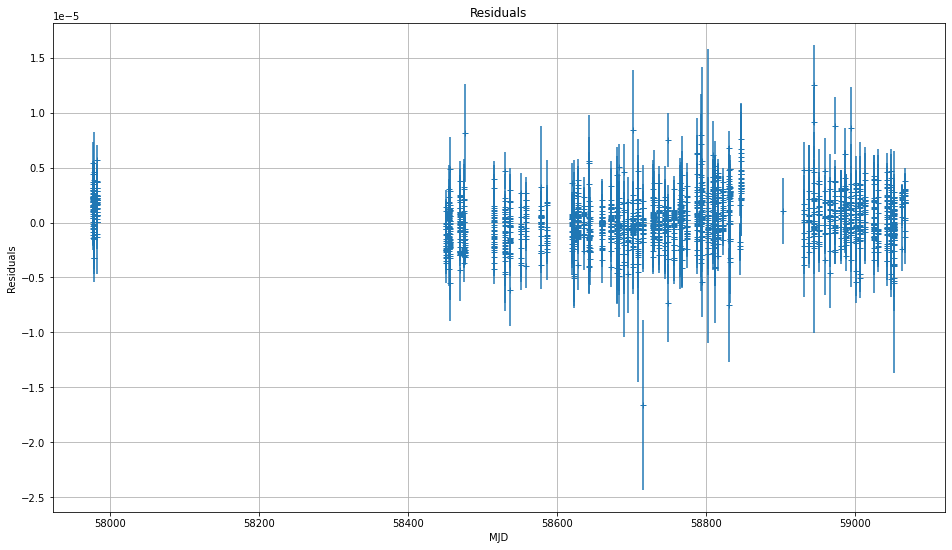

Removing 597 TOAs of 2185 as outliers
Postfit RMS =  0.7625676266077587 us


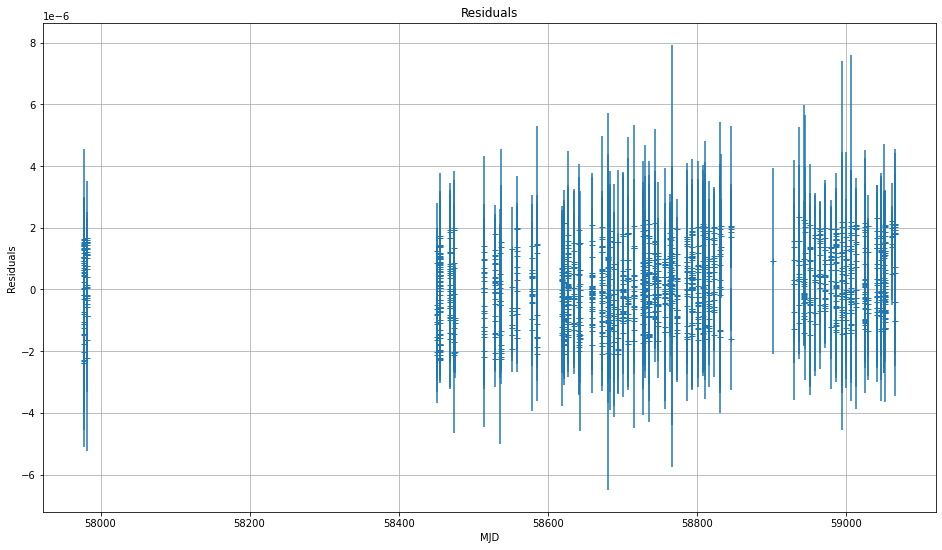

Working on J1640+2224
INFO: Par file created: 2022-03-05T23:52:09.688432 [timing_analysis.timingconfiguration]
INFO: Selecting 14066 TOAs out of 22412 (8346 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 14066 TOAs out of 22412 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 14066 TOAs out of 22412 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  1.0346702962168834 us


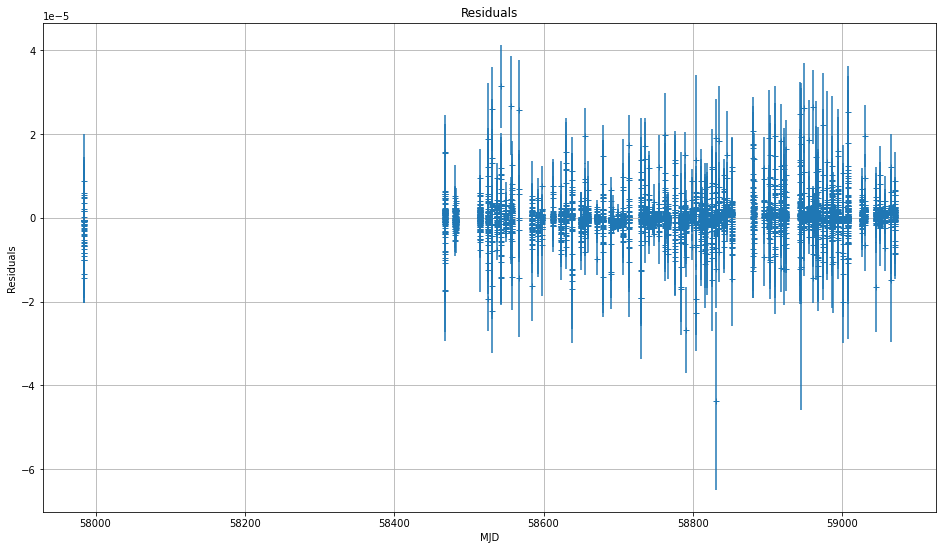

Removing 718 TOAs of 4782 as outliers
Postfit RMS =  0.9778122813433591 us


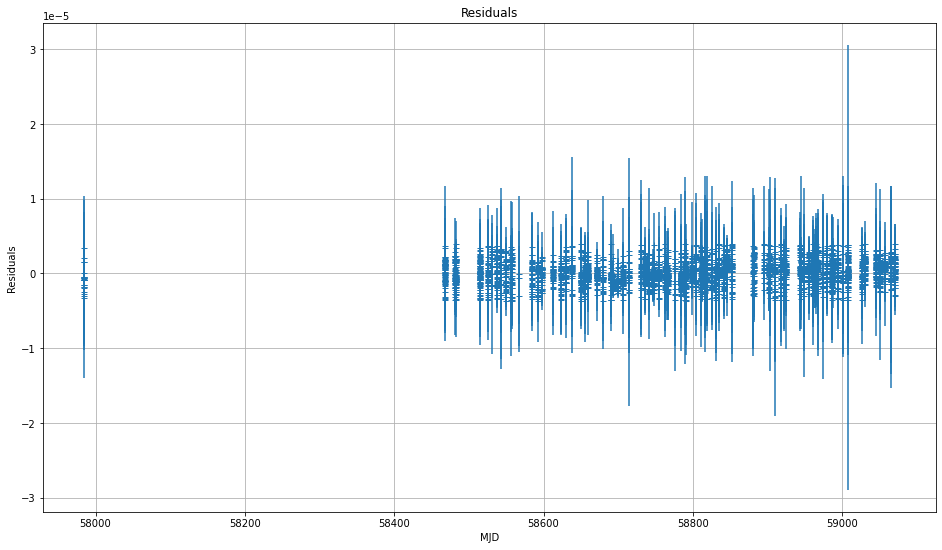

Working on J0931-1902
INFO: Par file created: 2022-03-01T17:55:27.897983 [timing_analysis.timingconfiguration]
INFO: Selecting 5473 TOAs out of 10870 (5397 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 5473 TOAs out of 10870 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 5473 TOAs out of 10870 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  10.438442755546335 us


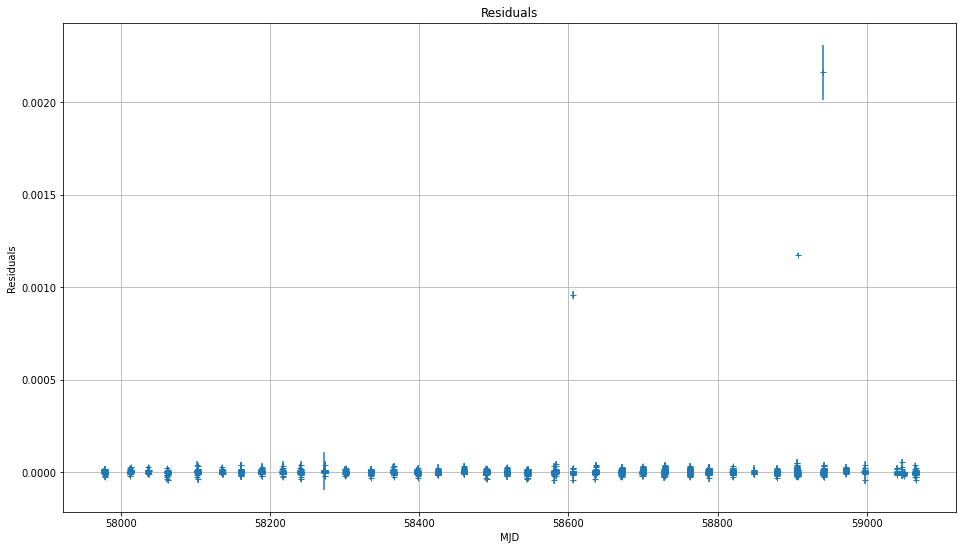

Removing 4 TOAs of 3015 as outliers
Postfit RMS =  5.183564975488856 us


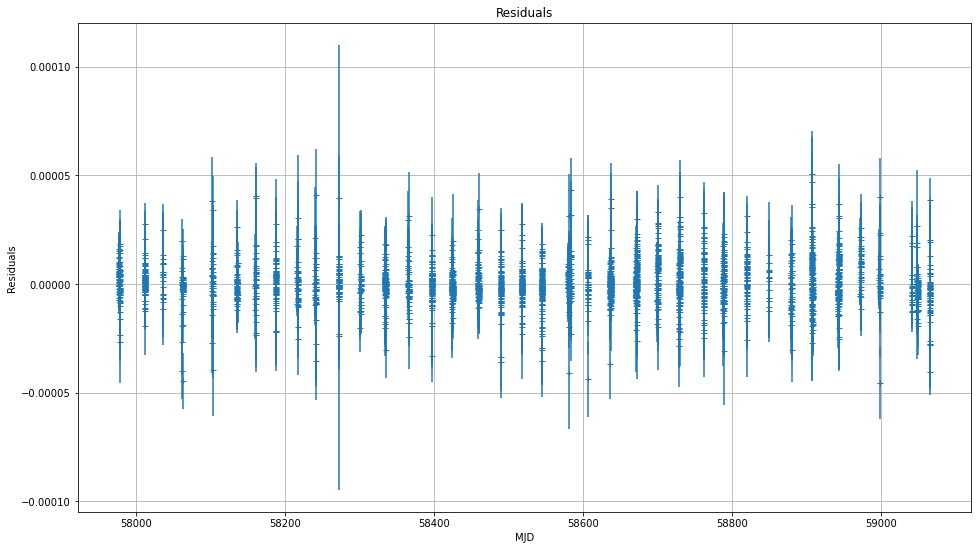

Working on J0509+0856
INFO: Par file created: 2022-03-02T01:15:19.912920 [timing_analysis.timingconfiguration]
INFO: Selecting 2172 TOAs out of 4710 (2538 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 2169 TOAs out of 4710 (3 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 2169 TOAs out of 4710 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  5.25838435076476 us


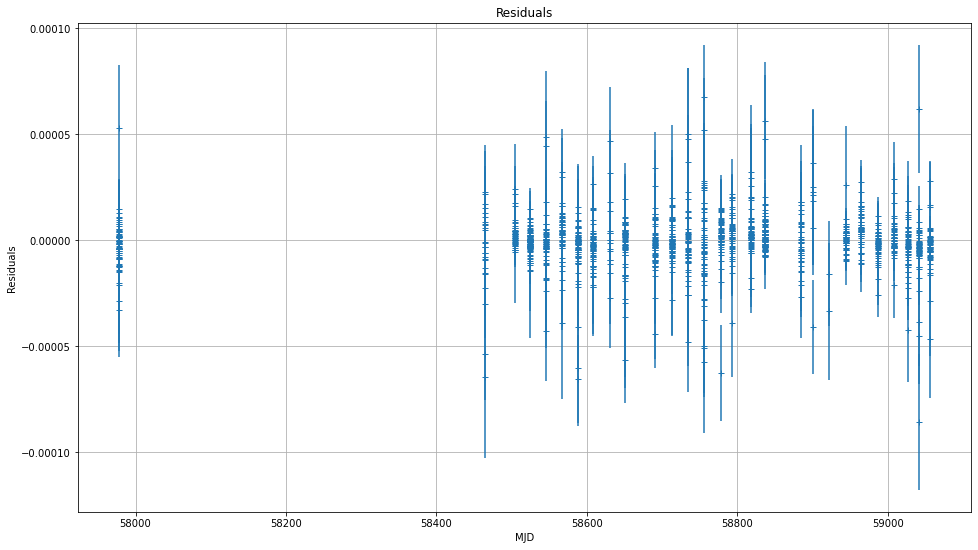

Removing 254 TOAs of 1465 as outliers
Postfit RMS =  4.186779841845727 us


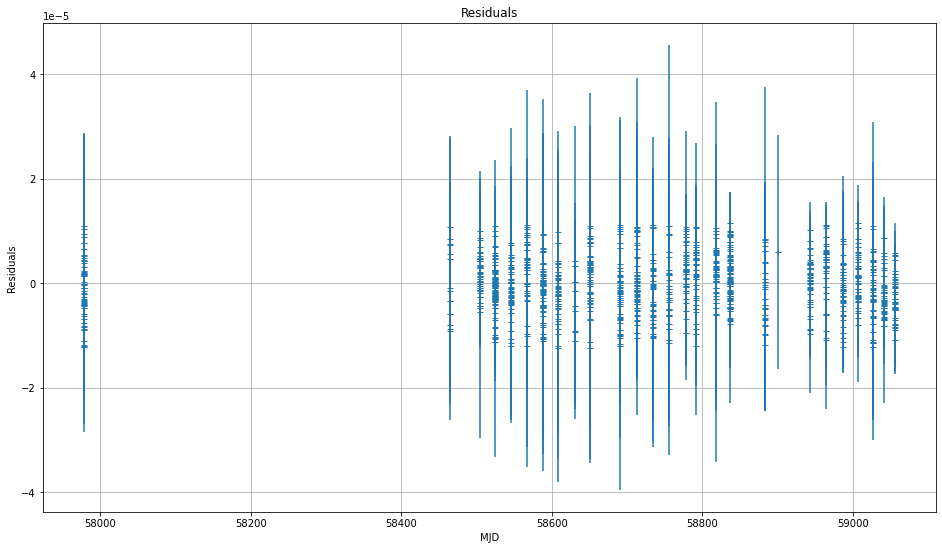

Working on J0605+3757
INFO: Par file created: 2022-03-01T15:35:44.593388 [timing_analysis.timingconfiguration]
INFO: Selecting 554 TOAs out of 3999 (3445 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 554 TOAs out of 3999 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 554 TOAs out of 3999 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  4.421325653227233 us


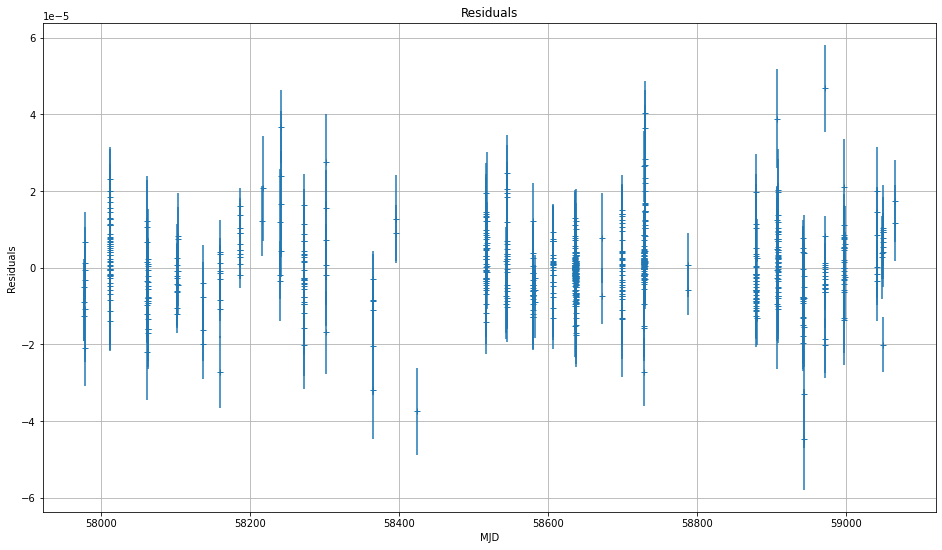

Removing 182 TOAs of 758 as outliers
Postfit RMS =  2.7198280124677425 us


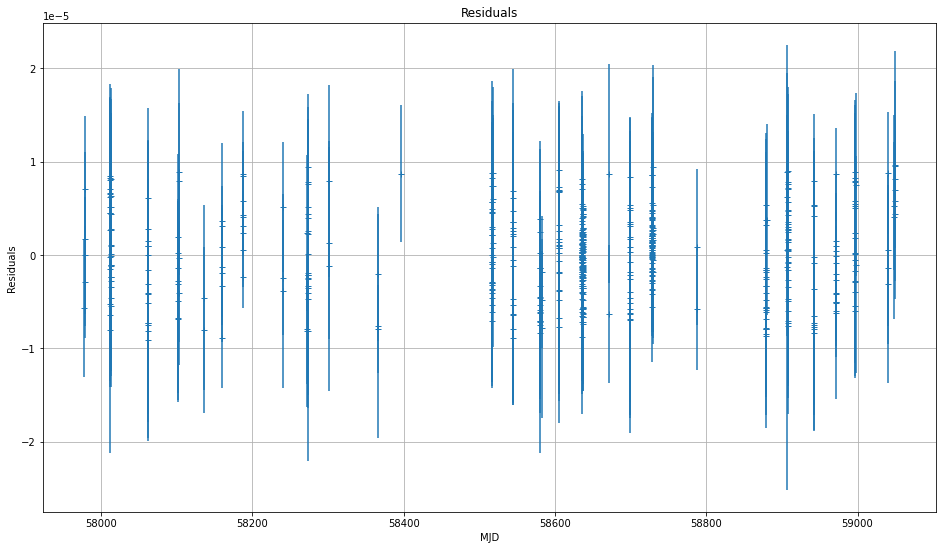

Working on J1903+0327
INFO: Par file created: 2022-03-04T20:06:24.349662 [timing_analysis.timingconfiguration]
INFO: Selecting 6857 TOAs out of 10958 (4101 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 6856 TOAs out of 10958 (1 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 6856 TOAs out of 10958 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'JUMP2', 'DM']
Postfit RMS =  4.109090759474525 us


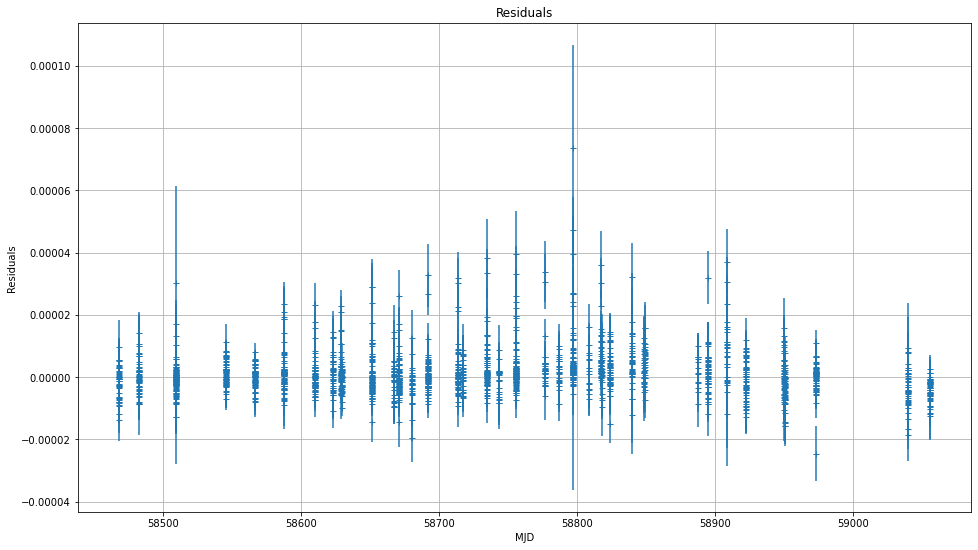

Removing 371 TOAs of 1914 as outliers
Postfit RMS =  2.830970880314165 us


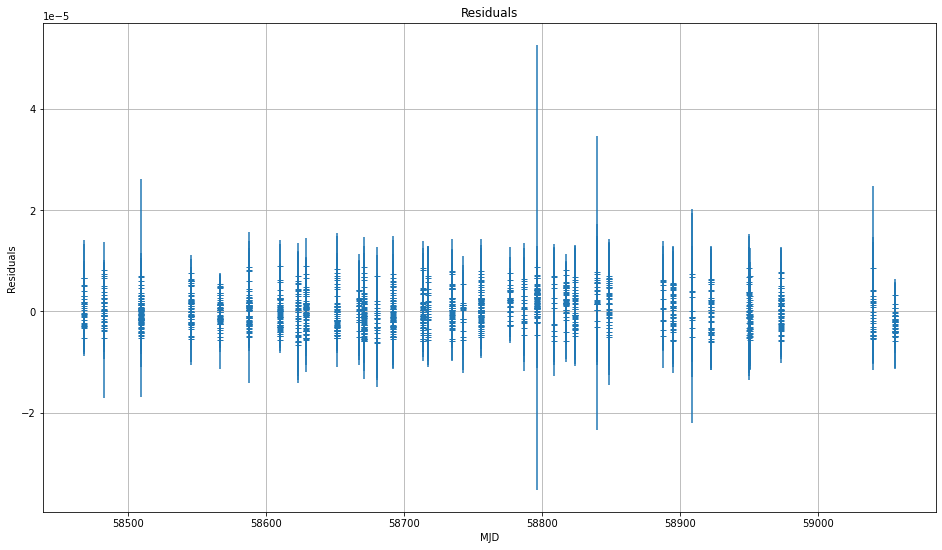

Working on J0636+5128
INFO: Par file created: 2022-03-03T21:02:28.087988 [timing_analysis.timingconfiguration]
INFO: Selecting 32223 TOAs out of 70480 (38257 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 32222 TOAs out of 70480 (1 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 32222 TOAs out of 70480 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM', 'FB0', 'TASC']
Postfit RMS =  9.867288377609789 us


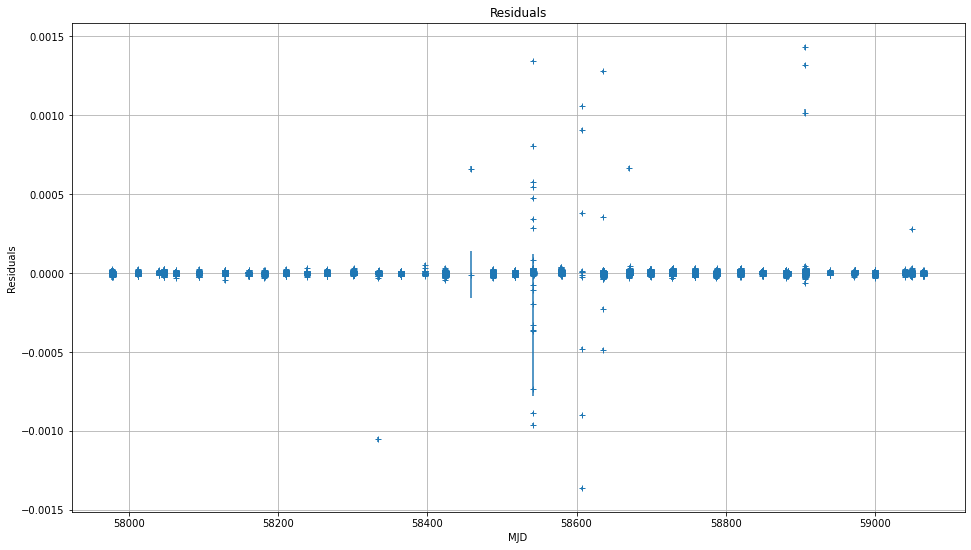

Removing 49 TOAs of 19342 as outliers
Postfit RMS =  4.655372079338105 us


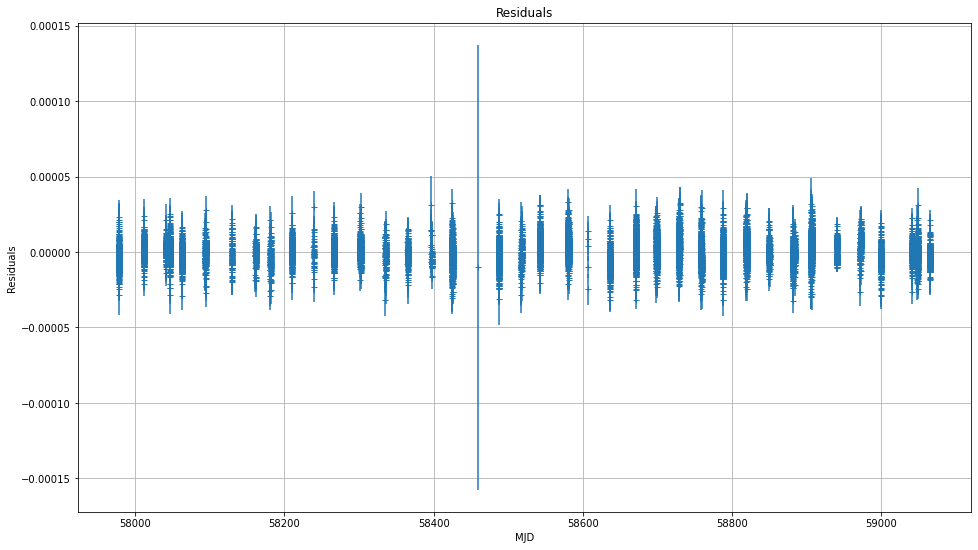

Working on J0437-4715
INFO: Par file created: 2022-03-01T21:01:27.136599 [timing_analysis.timingconfiguration]
INFO: Selecting 6049 TOAs out of 6953 (904 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 6049 TOAs out of 6953 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-file'} [timing_analysis.timingconfiguration]
INFO: Selecting 5830 TOAs out of 6953 (219 more removed based on manual cuts, specified keys). [timing_analysis.utils]


ERROR: No quicklook TOAs for J0437-4715.   [unknown]


Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  0.8499499000272445 us


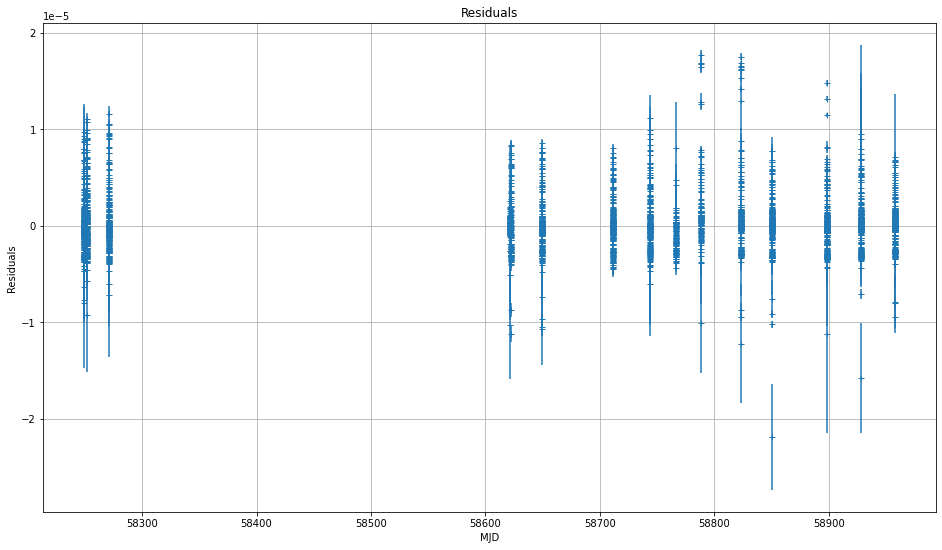

Removing 753 TOAs of 3078 as outliers
Postfit RMS =  0.6007975651280862 us


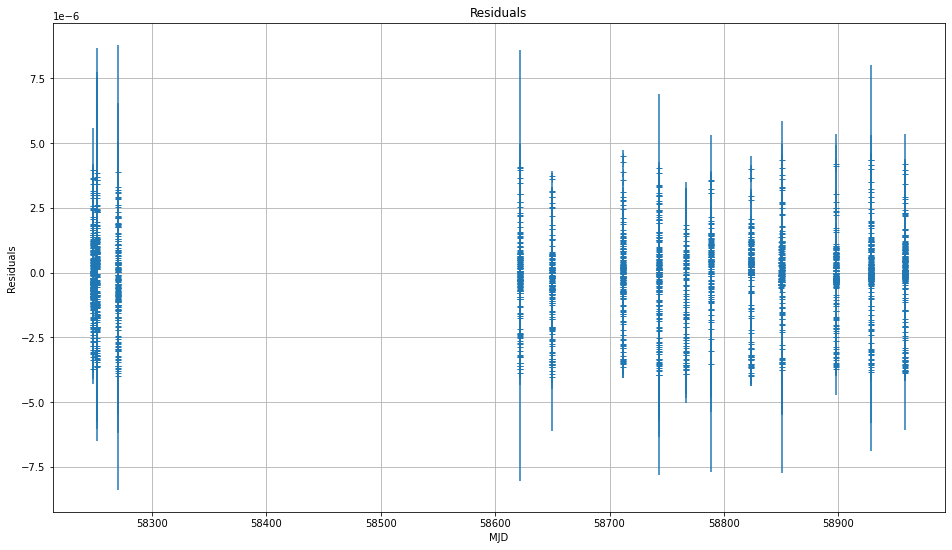

Working on J1745+1017
INFO: Par file created: 2022-03-02T08:43:36.760122 [timing_analysis.timingconfiguration]
INFO: Selecting 3017 TOAs out of 5717 (2700 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 3017 TOAs out of 5717 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 3017 TOAs out of 5717 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  6.760030980425997 us


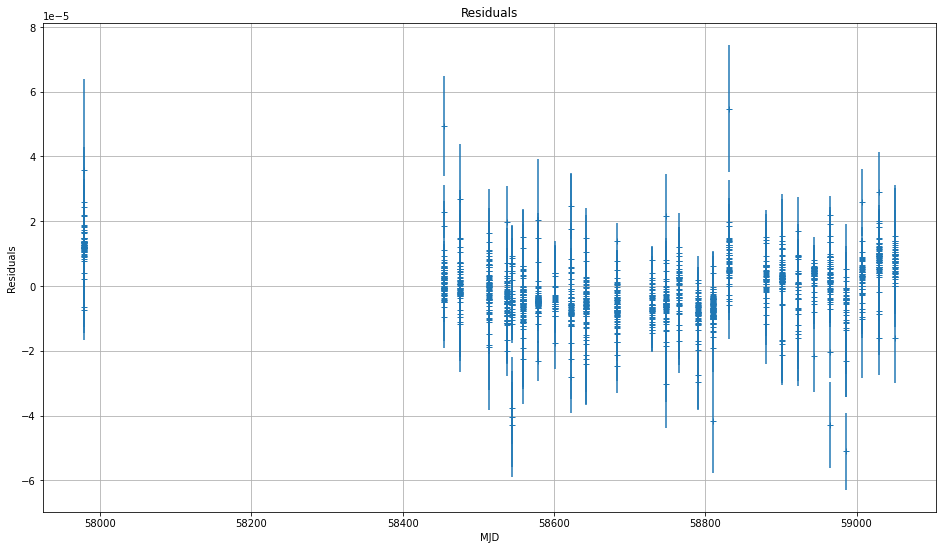

Removing 399 TOAs of 1566 as outliers
Postfit RMS =  4.403836153485403 us


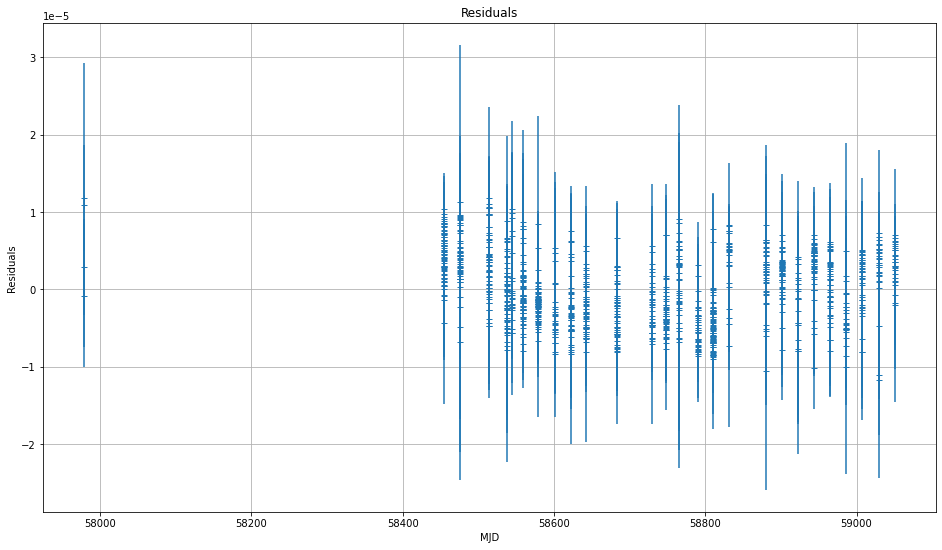

Working on J0709+0458
INFO: Par file created: 2022-03-02T05:57:16.325883 [timing_analysis.timingconfiguration]
INFO: Selecting 3033 TOAs out of 5933 (2900 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 3030 TOAs out of 5933 (3 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 3030 TOAs out of 5933 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]


ERROR: No quicklook TOAs for J0709+0458.   [unknown]


Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  10.550279967754909 us


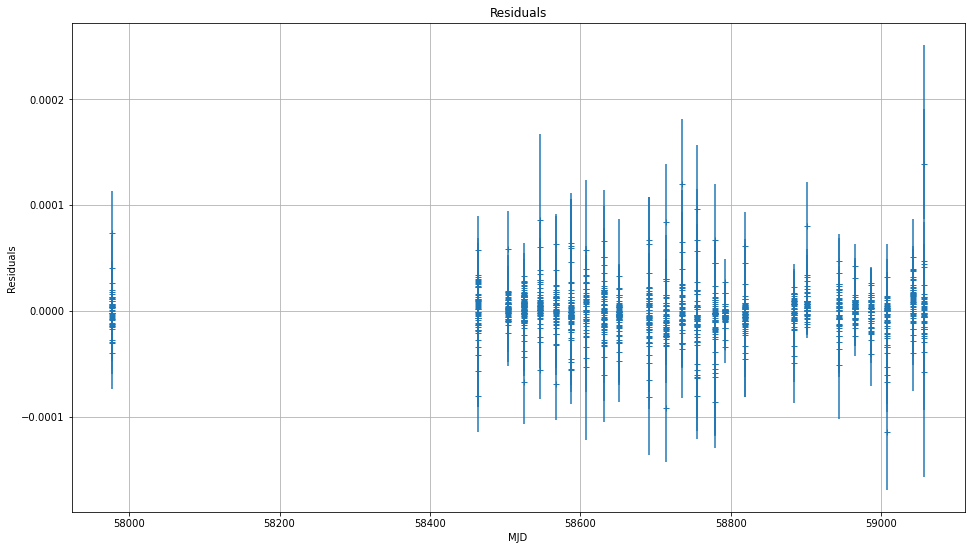

Removing 273 TOAs of 1365 as outliers
Postfit RMS =  7.710362361571037 us


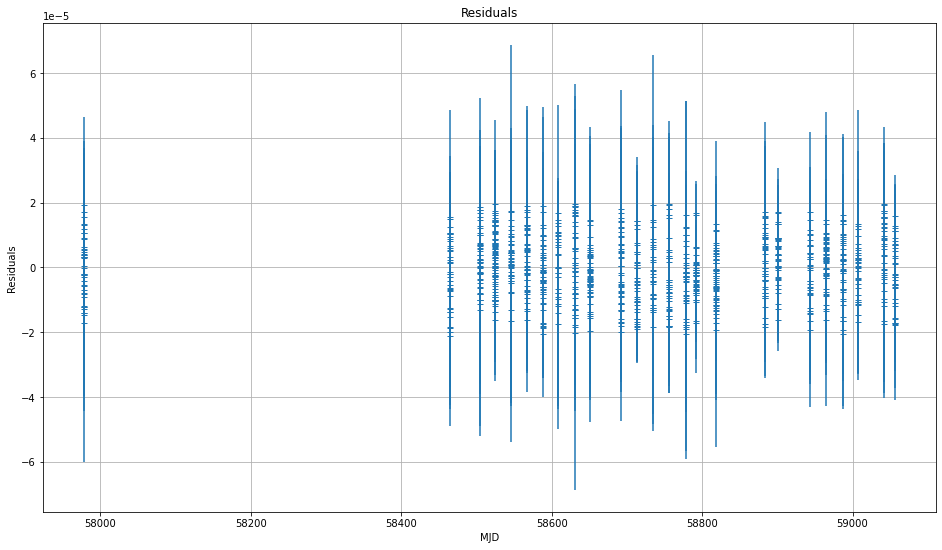

Working on J0645+5158
INFO: Par file created: 2022-03-02T06:35:51.515942 [timing_analysis.timingconfiguration]
INFO: Selecting 10404 TOAs out of 17671 (7267 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: {'bad-toa'} [timing_analysis.timingconfiguration]
INFO: Selecting 10403 TOAs out of 17671 (1 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 10403 TOAs out of 17671 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM']
Postfit RMS =  2.391430475229358 us


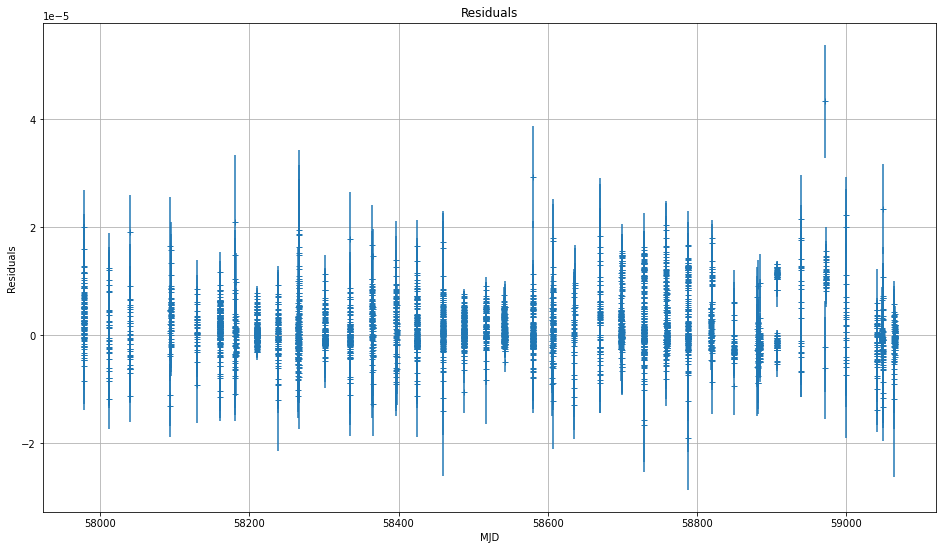

Removing 913 TOAs of 3882 as outliers
Postfit RMS =  1.3590473815551405 us


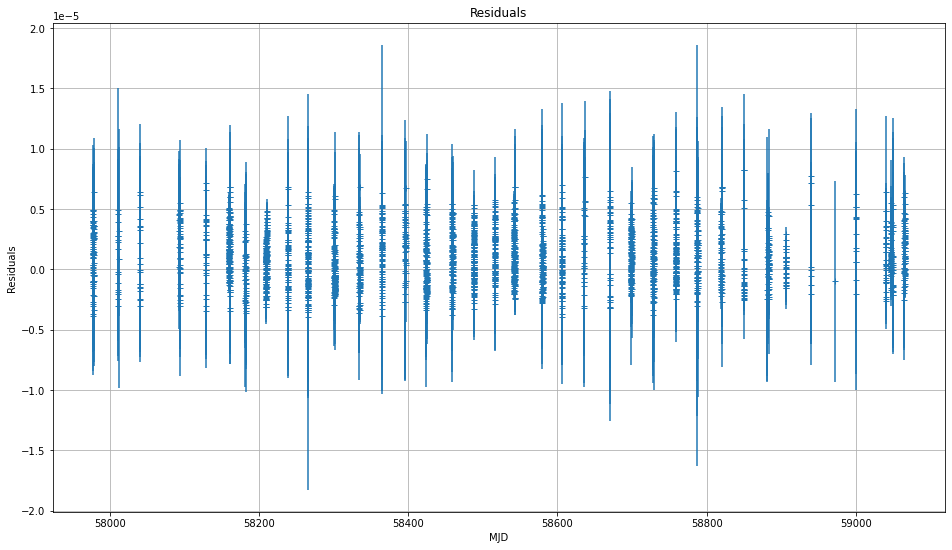

Working on J1705-1903
INFO: Par file created: 2022-03-07T16:29:37.391995 [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (10483 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]


In [ ]:
# Set TOA and config file locations:
quicklookdir = "/nanograv/timing/pipeline/quicklook/data/vegas/"
configs=glob.glob("/home/jovyan/work/timing_analysis/configs/*.nb.yaml")
configs = [x for x in configs if ("gbt" not in x and "ao" not in x)]
#psrs=['J0931-1902','J0709+0458']
psrs = {os.path.split(x)[1].split(".")[0] for x in configs}
niter = 3 #Iterations for fitting
#Input range of data-set (*For 15 yr data-release, adding last three years only*)
MJDlow = 57976 *au.d  #11Aug,2017
MJDhigh = 59071 *au.d  #10Aug,2020
if not os.path.exists('simple_ephem_tg_new/'):
    os.mkdir('simple_ephem_tg_new/')
print("Pulsars for which predictive par files are being generated: ", psrs)
for psr in psrs:
    print(f"Working on {psr}")
    configfile = [x for x in configs if psr in x][0]
    # intantiate the class and load TOAs
    t=Pred_par(psr,configfile,MJDlow,MJDhigh) 
    mo,to = t.load_toas()
    # Apply manual cuts
    t.cut_toas(to)
    # J1705-1903 is drifting so bad we need a special starting model
    #if psr=="J1705-1903":
    #    mo = pm.get_model("J1705-1903_start.par")
    # B1937+21 needs a dmx model, so the full par file is the one that must be used
    if psr=="B1937+21":
        mo.write_parfile(f"simple_ephem_tg_new/{psr}_pred.par", format="tempo")
        continue
    # Load and merge quicklook TOAs
    tqfilenms = glob.glob(f"{quicklookdir}/{psr}/{psr}*.quicklook.x.nb.tim")
    if len(tqfilenms)==0:
        log.error(f"No quicklook TOAs for {psr}.  ")
        tall=to
    else:
        tall = t.load_merge_qck_toas(tqfilenms,quicklookdir,to,mo)
    tall.table = tall.table[:]
    tall.compute_pulse_numbers(mo)
    # Create an initial simple model
    ms = t.simplify_parfile(tall, f"simple_ephem_tg_new/{psr}_simple.par")
    t.freeze_fit_pars(ms)
    # Remove TOAs outside the range provided
    tall.table = tall.table[t.MJDlow < tall.get_mjds()]
    tall.table = tall.table[t.MJDhigh > tall.get_mjds()]
    # Calculate the pulse numbers based on the 15yr solutions
    tall.compute_pulse_numbers(mo)
    # Use a simple WLS fitter
    f=t.fit_TOAs(tall,ms,niter)
    f.plot()
    t.cut_outliers(f)
    f=t.fit_TOAs(tall,ms,niter)
    f.plot()
    # Write the new parfile and remove simple ones to avoid confusion
    f.model.CLOCK.value = "TT(BIPM)"
    f.model.write_parfile(f"simple_ephem_tg_new/{psr}_pred.par", format="tempo")
    if os.path.exists(f"simple_ephem_tg_new/{psr}_simple.par"):
        os.remove(f"simple_ephem_tg_new/{psr}_simple.par")
    
    

Pulsars for which predictive par files are being generated:  ['J1705-1903']
Working on J1705-1903
INFO: Par file created: 2022-03-07T16:29:37.391995 [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (10483 removed based on existing cuts, pre-excised). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
INFO: Specified TOA excision keys: set() [timing_analysis.timingconfiguration]
INFO: Selecting 9871 TOAs out of 20354 (0 more removed based on manual cuts, specified keys). [timing_analysis.utils]
Free params: ['F0', 'JUMP1', 'DM', 'FB0', 'TASC']
Postfit RMS =  8.660919089374623 us


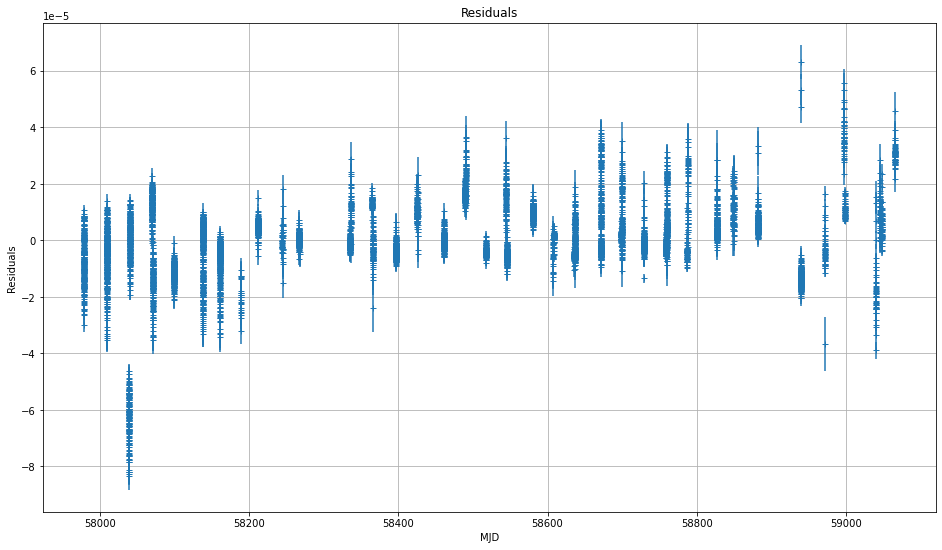

Removing 1658 TOAs of 8030 as outliers
Postfit RMS =  5.956105875962737 us


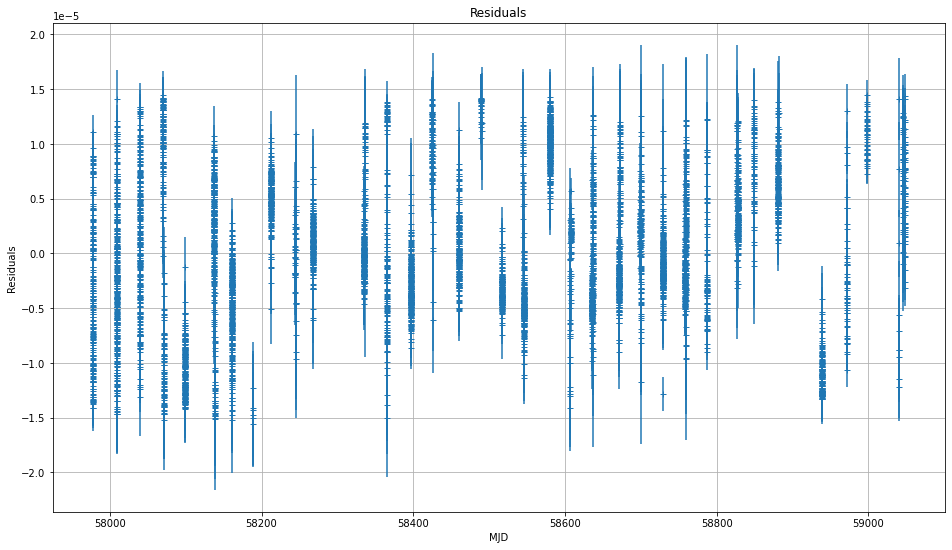

In [10]:
# Set TOA and config file locations:
quicklookdir = "/nanograv/timing/pipeline/quicklook/data/vegas/"
configs=glob.glob("/home/jovyan/work/timing_analysis/configs/*.nb.yaml")
configs = [x for x in configs if ("gbt" not in x and "ao" not in x)]
psrs=['J1705-1903']#,'J1802-2124','B1937+21'] 
      #J0931-1902','J0709+0458']
#psrs = {os.path.split(x)[1].split(".")[0] for x in configs}
niter = 3 #Iterations for fitting
#Input range of data-set (*confirm for 15 yr*)
MJDlow = 57976 *au.d  #11Aug,2017
MJDhigh = 59071 *au.d  #10Aug,2020

print("Pulsars for which predictive par files are being generated: ", psrs)
for psr in psrs:
    print(f"Working on {psr}")
    configfile = [x for x in configs if psr in x][0]
    # intantiate the class and load TOAs
    t=Pred_par(psr,configfile,MJDlow,MJDhigh) 
    mo,to = t.load_toas()
    # Apply manual cuts
    t.cut_toas(to)
    # J1705-1903 is drifting so bad we need a special starting model
    #if psr=="J1705-1903":
    #    mo = pm.get_model("J1705-1903_start.par")
    # B1937+21 needs a dmx model, so the full par file is the one that is be used here
    if psr=="B1937+21":
        mo.write_parfile(f"simple_ephem_tg/{psr}_pred.par", format="tempo")
        continue
    # Load and merge quicklook TOAs
    tqfilenms = glob.glob(f"{quicklookdir}/{psr}/{psr}*.quicklook.x.nb.tim")
    if len(tqfilenms)==0:
        log.error(f"No quicklook TOAs for {psr}.  ")
        tall=to
    else:
        tall = t.load_merge_qck_toas(tqfilenms,quicklookdir,to,mo)
    tall.table = tall.table[:]
    tall.compute_pulse_numbers(mo)
    # Create an initial simple model
    ms = t.simplify_parfile(tall, f"simple_ephem_tg/{psr}_simple.par")
    t.freeze_fit_pars(ms)
    # Remove TOAs outside the range provided
    tall.table = tall.table[t.MJDlow < tall.get_mjds()]
    tall.table = tall.table[t.MJDhigh > tall.get_mjds()]
    # Calculate the pulse numbers based on the 15yr solutions
    tall.compute_pulse_numbers(mo)
    # Use a simple WLS fitter
    f=t.fit_TOAs(tall,ms,niter)
    f.plot()
    t.cut_outliers(f)
    f=t.fit_TOAs(tall,ms,niter)
    f.plot()
    # Write the new parfile
    #f.model.CLOCK.value = "TT(BIPM)"
    #f.model.write_parfile(f"simple_ephem_tg/{psr}_pred.par", format="tempo")
    
    